In [21]:
!pip install plaid-python

In [22]:
import getpass, os

os.environ["PLAID_CLIENT_ID"] = getpass.getpass("PLAID_CLIENT_ID: ")
os.environ["PLAID_SECRET"] = getpass.getpass("PLAID_SECRET (Sandbox): ")

PLAID_CLIENT_ID: ··········
PLAID_SECRET (Sandbox): ··········


In [23]:
from plaid.api import plaid_api
from plaid.configuration import Configuration
from plaid.api_client import ApiClient
from plaid.model.sandbox_public_token_create_request import SandboxPublicTokenCreateRequest
from plaid.model.item_public_token_exchange_request import ItemPublicTokenExchangeRequest
from plaid.model.products import Products

config = Configuration(
    host="https://sandbox.plaid.com",
    api_key={
        "clientId": os.environ["PLAID_CLIENT_ID"],
        "secret": os.environ["PLAID_SECRET"],
    }
)
api_client = ApiClient(config)
client = plaid_api.PlaidApi(api_client)

# Pick a sandbox institution (this one is commonly used in examples)
public_token_resp = client.sandbox_public_token_create(
    SandboxPublicTokenCreateRequest(
        institution_id="ins_109508",
        initial_products=[Products("transactions")]
    )
)
public_token = public_token_resp["public_token"]

exchange_resp = client.item_public_token_exchange(
    ItemPublicTokenExchangeRequest(public_token=public_token)
)
access_token = exchange_resp["access_token"]
access_token[:10], "…"

('access-san', '…')

In [26]:
from plaid.model.transactions_get_request import TransactionsGetRequest
from datetime import date
import pandas as pd

req = TransactionsGetRequest(
    access_token=access_token,
    start_date=date(2024,1,1),
    end_date=date(2024,12,31)
)

resp = client.transactions_get(req)

print("Total transactions:", len(resp["transactions"]))

df_tx = pd.DataFrame(resp["transactions"])
df_tx.head(), df_tx.shape

Total transactions: 100


(                                                   0
 0  {'account_id': 'rvmvk9PExvfj4PDxzp3ycRd3VobBxW...
 1  {'account_id': 'rvmvk9PExvfj4PDxzp3ycRd3VobBxW...
 2  {'account_id': 'rvmvk9PExvfj4PDxzp3ycRd3VobBxW...
 3  {'account_id': 'rvmvk9PExvfj4PDxzp3ycRd3VobBxW...
 4  {'account_id': 'qv8vP9kw3vfJ8PAErLnXhK3grxeLbv...,
 (100, 1))

In [31]:
import pandas as pd

# Convert Plaid model objects to plain dicts
tx_list = [t.to_dict() if hasattr(t, "to_dict") else t for t in df_tx[0]]

# Now flatten
df_flat = pd.json_normalize(tx_list)

print(df_flat.shape)
print(df_flat.columns.tolist()[:20])
df_flat.head(3)

(100, 45)
['account_id', 'account_owner', 'amount', 'authorized_date', 'authorized_datetime', 'category', 'category_id', 'check_number', 'counterparties', 'date', 'datetime', 'iso_currency_code', 'logo_url', 'merchant_entity_id', 'merchant_name', 'name', 'payment_channel', 'pending', 'pending_transaction_id', 'personal_finance_category_icon_url']


,account_id,account_owner,amount,authorized_date,authorized_datetime,category,category_id,check_number,counterparties,date,...,payment_meta.payee,payment_meta.by_order_of,payment_meta.payer,payment_meta.payment_method,payment_meta.payment_processor,payment_meta.reason,personal_finance_category.confidence_level,personal_finance_category.detailed,personal_finance_category.primary,personal_finance_category.version
0,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,None,500.0,None,None,None,None,None,[],2024-12-30,...,None,None,None,None,None,None,LOW,ENTERTAINMENT_SPORTING_EVENTS_AMUSEMENT_PARKS_...,ENTERTAINMENT,v2
1,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,None,2078.5,None,None,None,None,None,[],2024-12-29,...,None,None,None,None,None,None,LOW,TRANSFER_OUT_ACCOUNT_TRANSFER,TRANSFER_OUT,v2
2,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,None,500.0,None,None,None,None,None,"[{'name': 'KFC', 'type': 'merchant', 'website'...",2024-12-29,...,None,None,None,None,None,None,VERY_HIGH,FOOD_AND_DRINK_FAST_FOOD,FOOD_AND_DRINK,v2


In [32]:
keep_candidates = [
    "transaction_id",
    "account_id",
    "amount",
    "date",
    "name",
    "merchant_name",
    "payment_channel",
    "pending",
    "category",
    "personal_finance_category.primary",
    "personal_finance_category.detailed"
]

keep = [c for c in keep_candidates if c in df_flat.columns]

df = df_flat[keep].copy()

print(df.shape)
df.head(3)

(100, 11)


,transaction_id,account_id,amount,date,name,merchant_name,payment_channel,pending,category,personal_finance_category.primary,personal_finance_category.detailed
0,VBNBvrJ43Bte7pgRWJ5wSm4l8VEpWWC9MvZd4,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,500.0,2024-12-30,Tectra Inc,None,in store,False,None,ENTERTAINMENT,ENTERTAINMENT_SPORTING_EVENTS_AMUSEMENT_PARKS_...
1,JJ7Jv9XLpJFrENmpov58c4epLJ6lkkfB8GeJ4,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,2078.5,2024-12-29,AUTOMATIC PAYMENT - THANK,None,online,False,None,TRANSFER_OUT,TRANSFER_OUT_ACCOUNT_TRANSFER
2,5k9kP68plkHn5Mm4voEJckEGQDM6bbF5rEQdn,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,500.0,2024-12-29,KFC,KFC,in store,False,None,FOOD_AND_DRINK,FOOD_AND_DRINK_FAST_FOOD


In [33]:
import numpy as np
rng = np.random.default_rng(42)

# A/B assignment
df["variant"] = rng.choice(
    ["A_strict", "B_simplified"],
    size=len(df),
    p=[0.5, 0.5]
)

# Features (signals)
df["abs_amount"] = df["amount"].abs()
df["is_high_amount"] = (df["abs_amount"] > 500).astype(int)
df["retries"] = rng.poisson(lam=0.6, size=len(df)).clip(0,5)

# Simulated friction score (proxy for institution difficulty)
df["bank_friction"] = (
    df["account_id"].astype(str).str[-2:]
      .apply(lambda x: int(x,16) if all(c in "0123456789abcdef" for c in x.lower()) else 5)
      % 10
) / 10

# Funnel probabilities
p_verified = 0.92 - 0.07*df["bank_friction"] - 0.04*df["is_high_amount"]
p_authorized = 0.90 - 0.05*df["retries"]
p_completed = (
    0.88
    + 0.03*(df["variant"]=="B_simplified")
    - 0.05*df["is_high_amount"]
    - 0.05*df["bank_friction"]
)

p_verified = np.clip(p_verified,0.05,0.99)
p_authorized = np.clip(p_authorized,0.05,0.99)
p_completed = np.clip(p_completed,0.05,0.99)

df["verified"] = rng.binomial(1,p_verified)
df["authorized"] = df["verified"] * rng.binomial(1,p_authorized)
df["transfer_completed"] = df["authorized"] * rng.binomial(1,p_completed)

df.head()

,transaction_id,account_id,amount,date,name,merchant_name,payment_channel,pending,category,personal_finance_category.primary,personal_finance_category.detailed,variant,abs_amount,is_high_amount,retries,bank_friction,verified,authorized,transfer_completed
0,VBNBvrJ43Bte7pgRWJ5wSm4l8VEpWWC9MvZd4,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,500.0,2024-12-30,Tectra Inc,None,in store,False,None,ENTERTAINMENT,ENTERTAINMENT_SPORTING_EVENTS_AMUSEMENT_PARKS_...,B_simplified,500.0,0,2,0.5,1,1,1
1,JJ7Jv9XLpJFrENmpov58c4epLJ6lkkfB8GeJ4,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,2078.5,2024-12-29,AUTOMATIC PAYMENT - THANK,None,online,False,None,TRANSFER_OUT,TRANSFER_OUT_ACCOUNT_TRANSFER,A_strict,2078.5,1,2,0.5,1,1,0
2,5k9kP68plkHn5Mm4voEJckEGQDM6bbF5rEQdn,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,500.0,2024-12-29,KFC,KFC,in store,False,None,FOOD_AND_DRINK,FOOD_AND_DRINK_FAST_FOOD,B_simplified,500.0,0,0,0.5,1,1,1
3,wv8vMJZEPvf1wMZraPVxh5Qg3J9kvvtPXa1VG,rvmvk9PExvfj4PDxzp3ycRd3VobBxWi7wkmLd,500.0,2024-12-29,Madison Bicycle Shop,None,in store,False,None,GENERAL_MERCHANDISE,GENERAL_MERCHANDISE_SPORTING_GOODS,B_simplified,500.0,0,0,0.5,0,0,0
4,7o9o7lkqKoHgbPoLkaE5TlqB8GDMeetdkaBKQ,qv8vP9kw3vfJ8PAErLnXhK3grxeLbvigWyx8d,25.0,2024-12-20,CREDIT CARD 3333 PAYMENT *//,None,other,False,None,LOAN_PAYMENTS,LOAN_PAYMENTS_OTHER_PAYMENT,A_strict,25.0,0,0,0.1,1,1,1


In [34]:
from math import sqrt

a = df[df["variant"]=="A_strict"]["transfer_completed"]
b = df[df["variant"]=="B_simplified"]["transfer_completed"]

n1, n2 = len(a), len(b)
p1, p2 = a.mean(), b.mean()

p_pool = (a.sum()+b.sum())/(n1+n2)
se = sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
z = (p2-p1)/se

print("A conversion:", round(p1,4))
print("B conversion:", round(p2,4))
print("Absolute lift:", round(p2-p1,4))
print("Relative lift:", round((p2-p1)/p1,2))
print("z-score:", round(z,2))

A conversion: 0.6981
B conversion: 0.6383
Absolute lift: -0.0598
Relative lift: -0.09
z-score: -0.63


In [35]:
df["failure"] = 1 - df["transfer_completed"]

df["failure"].mean()

np.float64(0.33)

In [36]:
df["failure"] = 1 - df["transfer_completed"]

df["failure"].mean()

np.float64(0.33)

In [37]:
signal_summary = (
    df.groupby("is_high_amount")["failure"]
      .mean()
      .reset_index()
      .rename(columns={"failure":"failure_rate"})
)

signal_summary

,is_high_amount,failure_rate
0,0,0.345679
1,1,0.263158


In [38]:
df.groupby("variant")["failure"].mean()

,failure
variant,
A_strict,0.301887
B_simplified,0.361702


In [40]:
df.groupby("retries")["failure"].mean()

,failure
retries,
0,0.296296
1,0.393939
2,0.333333
4,0.000000


In [41]:
df.groupby("retries")["failure"].mean()

,failure
retries,
0,0.296296
1,0.393939
2,0.333333
4,0.000000


In [42]:
df.groupby(pd.cut(df["bank_friction"], bins=5))["failure"].mean()

/tmp/ipython-input-571/171066252.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["bank_friction"], bins=5))["failure"].mean()


,failure
bank_friction,
"(0.0996, 0.18]",0.166667
"(0.18, 0.26]",NaN
"(0.26, 0.34]",NaN
"(0.34, 0.42]",NaN
"(0.42, 0.5]",0.352273


In [43]:
from sklearn.ensemble import RandomForestClassifier

features = [
    "abs_amount",
    "is_high_amount",
    "retries",
    "bank_friction"
]

X = df[features]
y = df["failure"]

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X,y)

importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances

,0
abs_amount,0.592230
retries,0.297871
bank_friction,0.062590
is_high_amount,0.047309


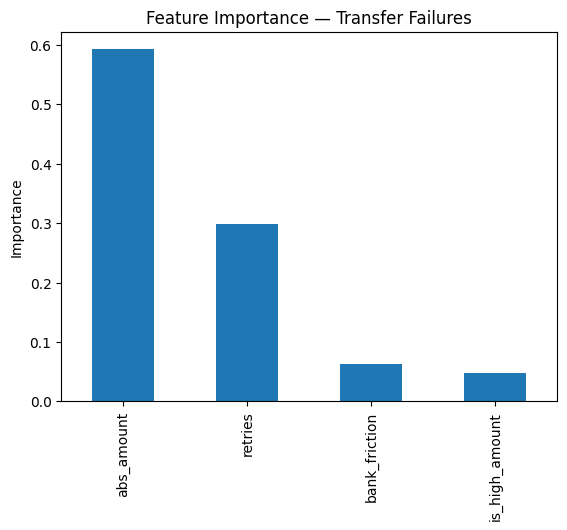

In [45]:
import matplotlib.pyplot as plt

importances.plot(kind="bar")
plt.title("Feature Importance — Transfer Failures")
plt.ylabel("Importance")
plt.show()